<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/simulations/RNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#Import Functions

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import random
from torch.utils.data import Dataset
import argparse, os, time
from torch.nn import init
import math
import networkx as nx
import pandas as pd

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import sys
sys.path.append('/content/drive/MyDrive/GNNs/')
from functions import *
from RNN import SingleRNNBaseline

ModuleNotFoundError: ignored

Parameters

In [5]:
params = {}
tau = 1
params['use_adam'] = True
params['test_burn_in_steps'] =40
params['num_time_steps'] = 50
params['data_path']= '/content/MyDrive/GNNs'
params['num_train'] = 3000
params['num_val'] = 1000
params['num_test']= 1000
params['load_model'] = False
params['load_best_model'] = False
params['model_type'] = 'RNN'
#params['graph_type'] = ['static', 'dynamic']
params['graph_type'] = 'dynamic'
params['encoder_no_factor'] = True
params['num_epochs'] = 100
params['num_vars'] = params['num_agents'] = 10
params['input_noise_type'] = 'none'
params['input_size'] = 4
params['nll_loss_type'] = 'gaussian'
params['prior_variance'] = 5e-5
params['batch_size'] = 64
params['val_batch_size'] = 64
params['accumulate_steps'] = 40
params['num_edge_types'] = 1
params['encoder_dropout'] = 0.0
params['encoder_hidden'] = 256
params['encoder_rnn_hidden'] = 64
params['encoder_rnn_type'] = 'lstm'
params['decoder_rnn_type'] = 'lstm'
params['encoder_mlp_num_layers'] = 1
params['encoder_mlp_hidden'] = 256
params['prior_num_layers'] = 1
params['prior_hidden_size'] = 256
params['gpu'] = False
params['decoder_hidden'] = 256
params['skip_first'] = False
params['decoder_dropout'] = 0.0
params['decoder_type'] = None
params['lr'] = 5e-4
params['mode'] = "train"

params['working_dir'] =params['output_dir'] =  ('/content/MyDrive/GNNs')

Dataset

In [45]:
df = pd.read_pickle("/content/drive/MyDrive/GNNs/boids_buffer_10_final1.csv")

In [46]:
df.shape

(5000, 4)

In [47]:
df.head()

,R,theta,velocity,trajectory
0,"[[1077.9397, 666.84686], [856.4423, 1137.0732]...","[2.9513416, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.927397, 0.8475409], [-0.11385684, 4.99870...","[[1077.9397, 666.84686, -4.927397, 0.8475409],..."
1,"[[1073.0123, 667.6944], [856.3285, 1142.072], ...","[2.9859188, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.9457974, 0.7338834], [-0.11385684, 4.9987...","[[1073.0123, 667.6944, -4.9457974, 0.7338834],..."
2,"[[1068.0665, 668.4283], [856.2146, 1147.0707],...","[3.0014527, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.954386, 0.6736986], [-0.11385684, 4.99870...","[[1068.0665, 668.4283, -4.954386, 0.6736986], ..."
3,"[[1063.112, 669.102], [856.10077, 1152.0693], ...","[3.0109863, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.9596305, 0.6340109], [-0.11385684, 4.9987...","[[1063.112, 669.102, -4.9596305, 0.6340109], [..."
4,"[[1058.1525, 669.736], [855.9869, 1157.0681], ...","[3.0177057, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.963271, 0.6048854], [-0.11385684, 4.99870...","[[1058.1525, 669.736, -4.963271, 0.6048854], [..."


In [48]:
data = []
for w in range(len(df)):
  
  state = np.array(df.R[w])
  D = list()
  for a,i in enumerate(state):
    d= []
    for b,j in enumerate(state):
      eDistance = math.hypot(i[0] - j[0], i[1] - j[1])
      if a == b:
        d.append(0)
      elif int(eDistance) <= 200:
        d.append(1)
      else:
        d.append(0)
    D.append(d)

  data.append(np.array(D))
edge_data = np.array(data)
all_data = np.array(list(df.trajectory))

adj_array = []
#print(edge_data.shape)
for time_step in range(len(edge_data)):
  edge = []
  for i in range(len(edge_data[0])):
    edge = edge + list(list(edge_data[time_step][i][:i])+list(edge_data[time_step][i][i+1:]))
    
  #print(len(edge[0].shape))
  adj_array.append(edge)

edge_data = np.array(adj_array)

In [49]:
all_data = np.stack(all_data)
train_data = torch.FloatTensor(all_data[:params['num_train']])
val_data = torch.FloatTensor(all_data[params['num_train']:params['num_train']+params['num_val']])
test_data = torch.FloatTensor(all_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

train_edges = torch.FloatTensor(edge_data[:params['num_train']])
val_edges = torch.FloatTensor(edge_data[params['num_train']:params['num_train']+params['num_val']])
test_edges = torch.FloatTensor(edge_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

In [50]:
del all_data, df,edge_data, data

In [51]:
print("Train Shape:", train_data.shape,"\n", 
       "Val Shape:", val_data.shape,"\n",
      "Test Shape:", test_data.shape)

Train Shape: torch.Size([3000, 10, 4]) 
 Val Shape: torch.Size([1000, 10, 4]) 
 Test Shape: torch.Size([1000, 10, 4])


In [52]:
train_data = train_data.reshape([int(params["num_train"]/50),50,10,4])
val_data = val_data.reshape([int(params["num_val"]/50),50,10,4])
test_data = test_data.reshape([int(params["num_test"]/50),50,10,4])

train_edges = train_edges.reshape([int(params['num_train']/50),50,90])
val_edges = val_edges.reshape([int(params['num_val']/50),50,90])
test_edges = test_edges.reshape([int(params['num_test']/50),50,90])

In [53]:
train_data = torch.nn.functional.normalize(train_data)
val_data = torch.nn.functional.normalize(val_data)
test_data = torch.nn.functional.normalize(test_data)

In [54]:
DATA = []

for i in range(train_data.shape[0]):
  DATA.append({'inputs':train_data[i].reshape([1,50,10,4]),'edges':train_edges[i].reshape([1,50,90])})

VAL = []

for i in range(val_data.shape[0]):
  VAL.append({'inputs':val_data[i].reshape([1,50,10,4]),'edges':val_edges[i].reshape([1,50,90])})

TEST = []

for i in range(test_data.shape[0]):
  TEST.append({'inputs':test_data[i].reshape([1,50,10,4]),'edges':test_edges[i].reshape([1,50,90])})

DNRI

Build Model

In [57]:
def build_model(params):
    if params['model_type'] == 'RNN':
        model = SingleRNNBaseline(params)
        print("dNRI MODEL: ",model)
    if params['load_best_model']:
        print("LOADING BEST MODEL")
        path = os.path.join(params['working_dir'], 'best_model')
        model.load(path)
    elif params['load_model']:
        print("LOADING MODEL FROM SPECIFIED PATH")
        model.load(params['load_model'])
    if params['gpu']:
        model.cuda()
    return model

In [58]:
m = SingleRNNBaseline(params)

Train

Evaluate Forward Prediction

In [81]:
params['mode'] = 'eval'

In [82]:
model = build_model(params)
if params['mode'] == 'train':
    with build_writers(params['working_dir']) as (train_writer, val_writer):
        result = train(model, train_data, val_data, params, train_writer, val_writer)

elif params['mode'] == 'eval':
    test_data = TEST
    forward_pred = 50 - params['test_burn_in_steps']
    test_mse  = eval_forward_prediction(model, test_data, params['test_burn_in_steps'], forward_pred, params)
    #path = os.path.join(params['working_dir'], params['error_out_name']%params['test_burn_in_steps'])
    #np.save(path, test_mse.cpu().numpy())
    test_mse_1 = test_mse[0].item()
    #test_mse_15 = test_mse[14].item()
    test_mse_10 = test_mse[9].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ",test_mse_1)
    #print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_10)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, VAL, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    #out_dir = os.path.join(params['working_dir'], 'preds')
    #os.makedirs(out_dir, exist_ok=True)
    #out_path = os.path.join(out_dir, 'encoder_edges.npy')
    #np.save(out_path, edges.numpy())

    plot_sample(model, test_data, params['test_burn_in_steps'], params)

elif params['mode'] == 'record_predictions':
    model.eval()
    burn_in = params['test_burn_in_steps']
    forward_pred = 50 - params['test_burn_in_steps']
    test_data = TEST
    if params['subject_ind'] == -1:
        val_data_loader = DataLoader(test_data, batch_size=params['batch_size'])
        all_predictions = []
        all_edges = []
        for batch_ind,batch in enumerate(val_data_loader):
            print("BATCH %d of %d"%(batch_ind+1, len(val_data_loader)))
            inputs = batch['inputs']
            if params['gpu']:
                inputs = inputs.cuda(non_blocking=True)
            with torch.no_grad():
                predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
                all_predictions.append(predictions)
                all_edges.append(edges)
        if params['error_suffix'] is not None:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects_%s.npy'%params['error_suffix'])
        else:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects.npy')

        predictions = torch.cat(all_predictions, dim=0)
        edges = torch.cat(all_edges, dim=0)

    else:
        data = test_data[params['subject_ind']]
        inputs = data['inputs'].unsqueeze(0)
        if params['gpu']:
            inputs = inputs.cuda(non_blocking=True)
        with torch.no_grad():
            predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
            predictions = predictions.squeeze(0)
            edges = edges.squeeze(0)
        out_path = os.path.join(params['working_dir'], 'preds/', 'subject_%d.npy'%args.subject_ind)
    tmp_dir = os.path.join(params['working_dir'], 'preds/')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    torch.save([predictions.cpu(), edges.cpu()], out_path)


dNRI MODEL:  SingleRNNBaseline(
  (rnn): LSTMCell(4, 256)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)
FORWARD PRED RESULTS:
	1 STEP:  0.0007493915036320686
	25 STEP:  0.5297693610191345


AttributeError: ignored

In [ ]:
model.predict(TEST[0])

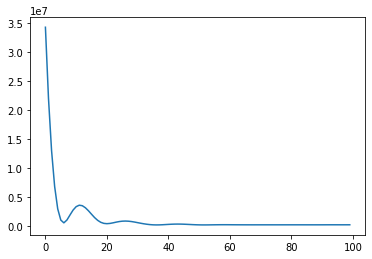

In [43]:
%matplotlib inline
plt.plot(result)
plt.show()

In [116]:
model_inputs = TEST[0]['inputs'][:, :40]
model_preds = model.predict_future(model_inputs, 10)
a = 2
x = []
y = []

for i in range(0,10):
  x.append(float(model_preds[0][i][a][0]))
  y.append(float(model_preds[0][i][a][1]))



p = []
q = []

for i in range(0,10):
  p.append(TEST[0]['inputs'][:,:-10][0][i][a][0])
  q.append(TEST[0]['inputs'][:,:-10][0][i][a][1])



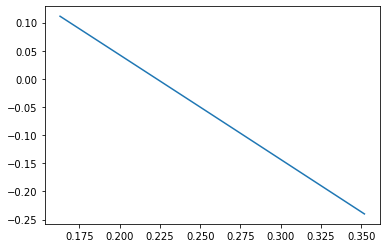

In [117]:
plt.plot(x,y)

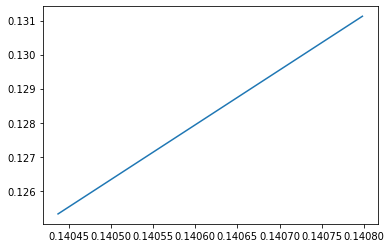

In [118]:
plt.plot(p,q)

VGAE Jax